In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [120]:
df_train = pd.read_csv("../dataset/train_cleaned.csv")
df_train_target = df_train.pop("CO2 Emissions(g/km)")
df_train_id = df_train.pop("Id")

df_test = pd.read_csv("../dataset/test_cleaned.csv")
df_test_id = df_test.pop("Id")

<Axes: >

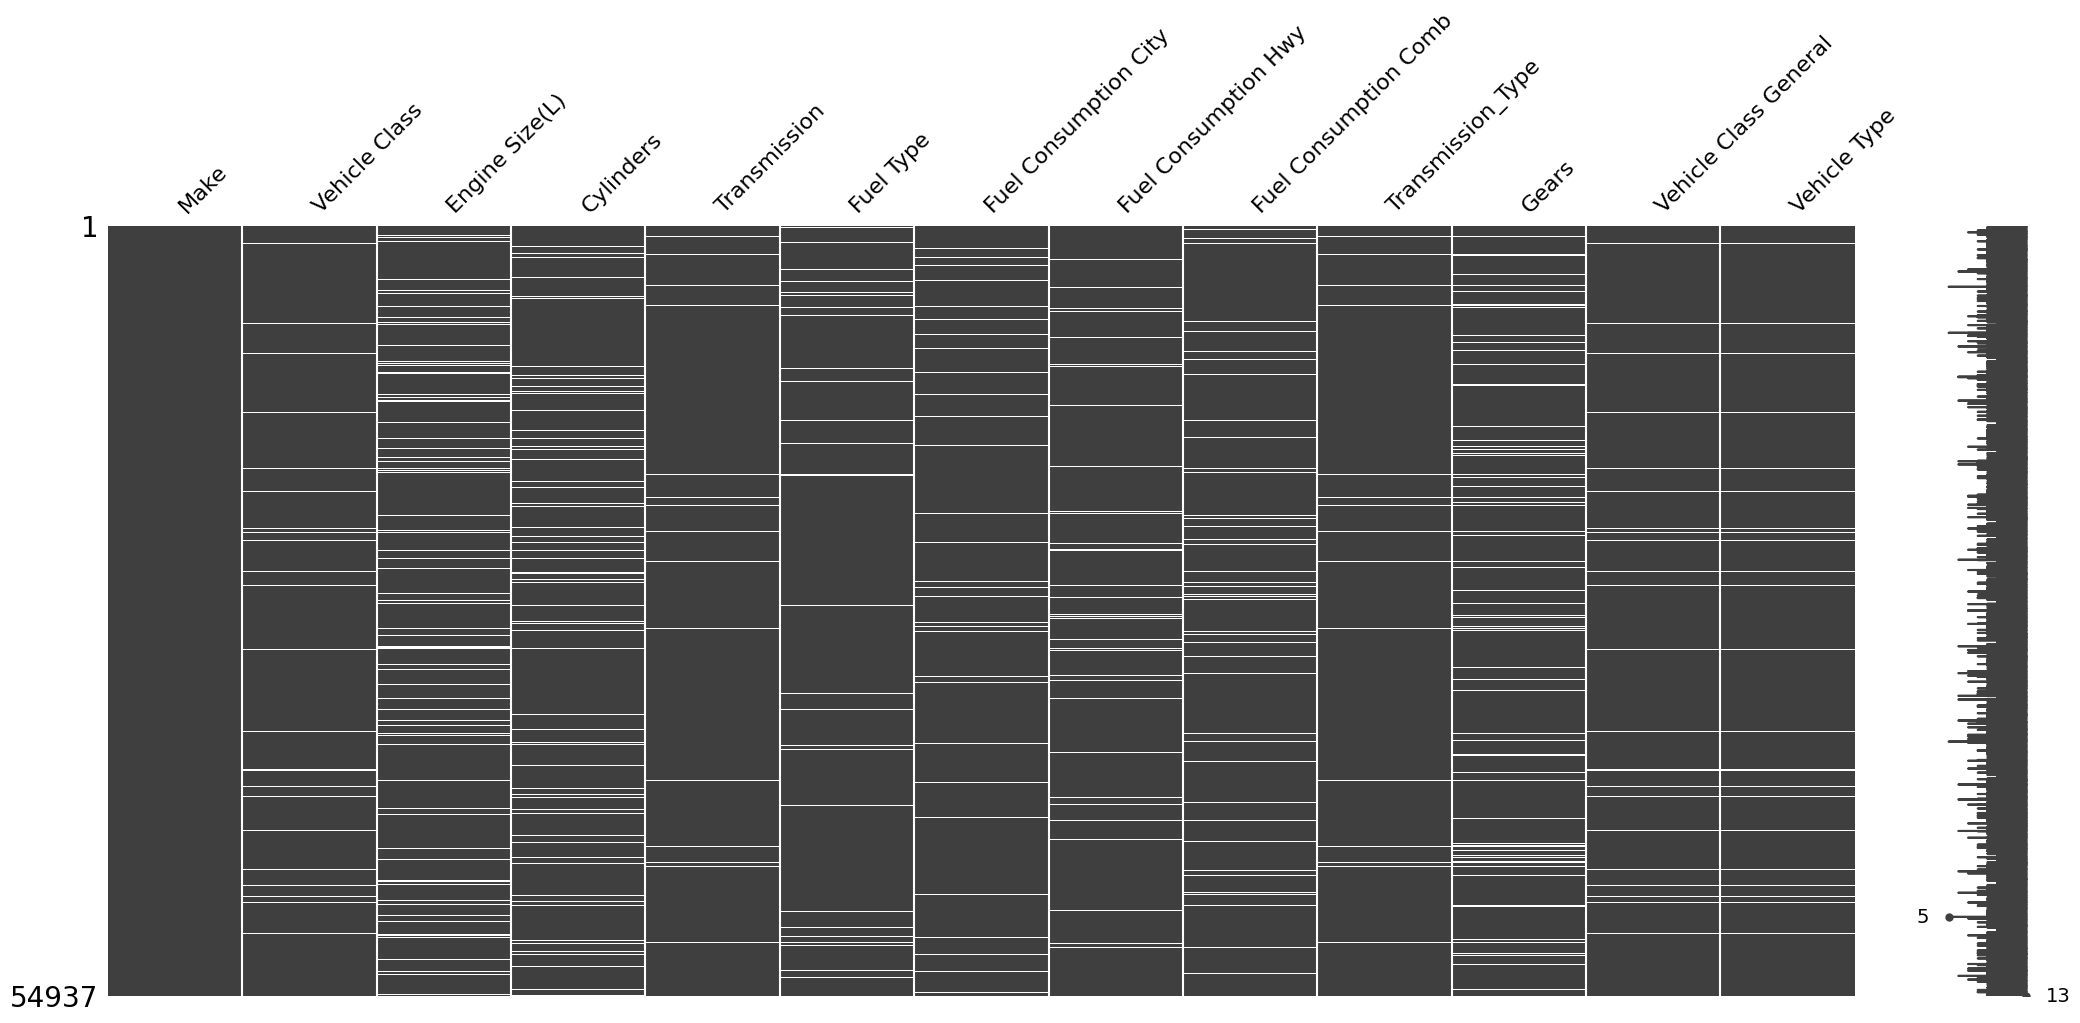

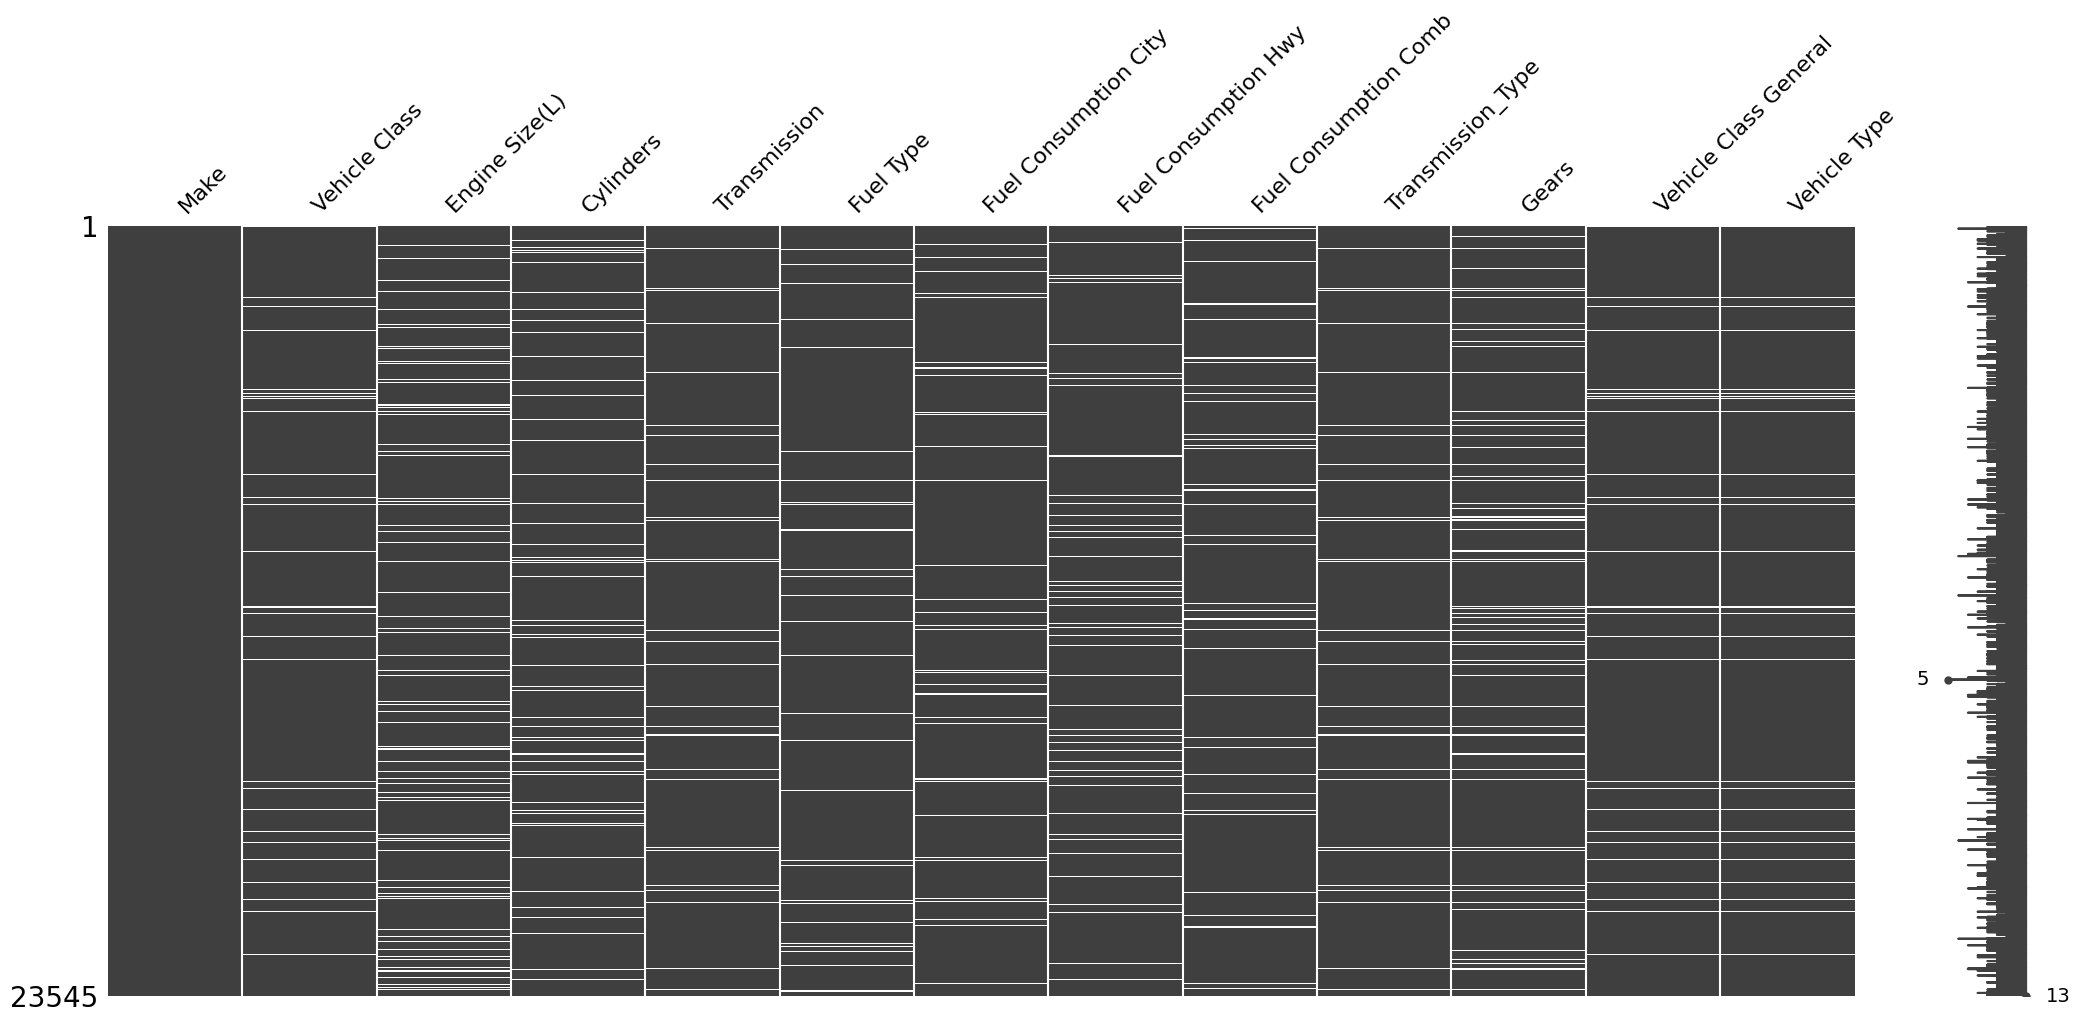

In [90]:
import missingno as msno

msno.matrix(df_train)
msno.matrix(df_test)

In [91]:
def find_rows_with_missing_values(
    df: pd.DataFrame, columns: list, n: int
) -> pd.DataFrame:
    return df[df[columns].isnull().sum(axis=1) >= n]

In [92]:
valid_columns = ["Make", "Vehicle Class", "Engine Size(L)", "Cylinders", "Transmission", "Fuel Type", "Fuel Consumption City", "Fuel Consumption Hwy", "Fuel Consumption Comb"]

multiple_missing_train = find_rows_with_missing_values(
    df_train, valid_columns, 4
)
multiple_missing_test = find_rows_with_missing_values(
    df_test, valid_columns, 4
)

<Axes: >

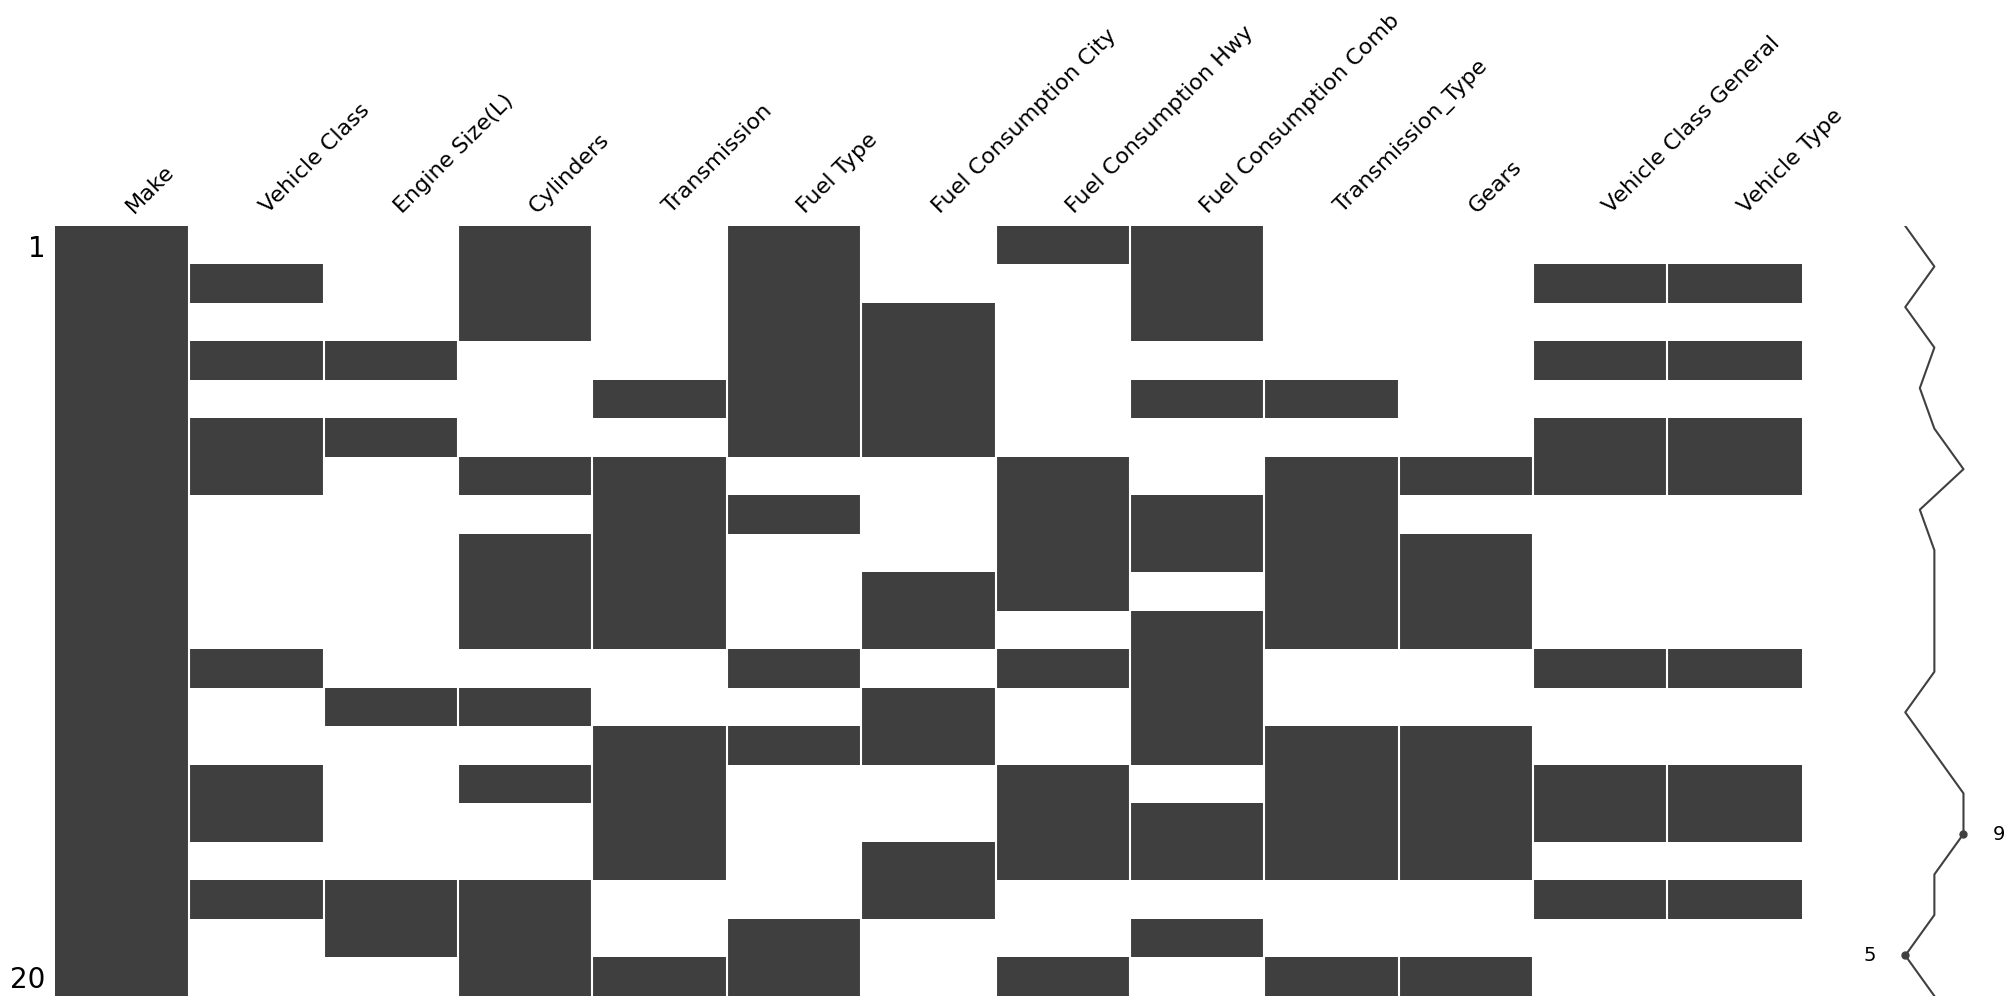

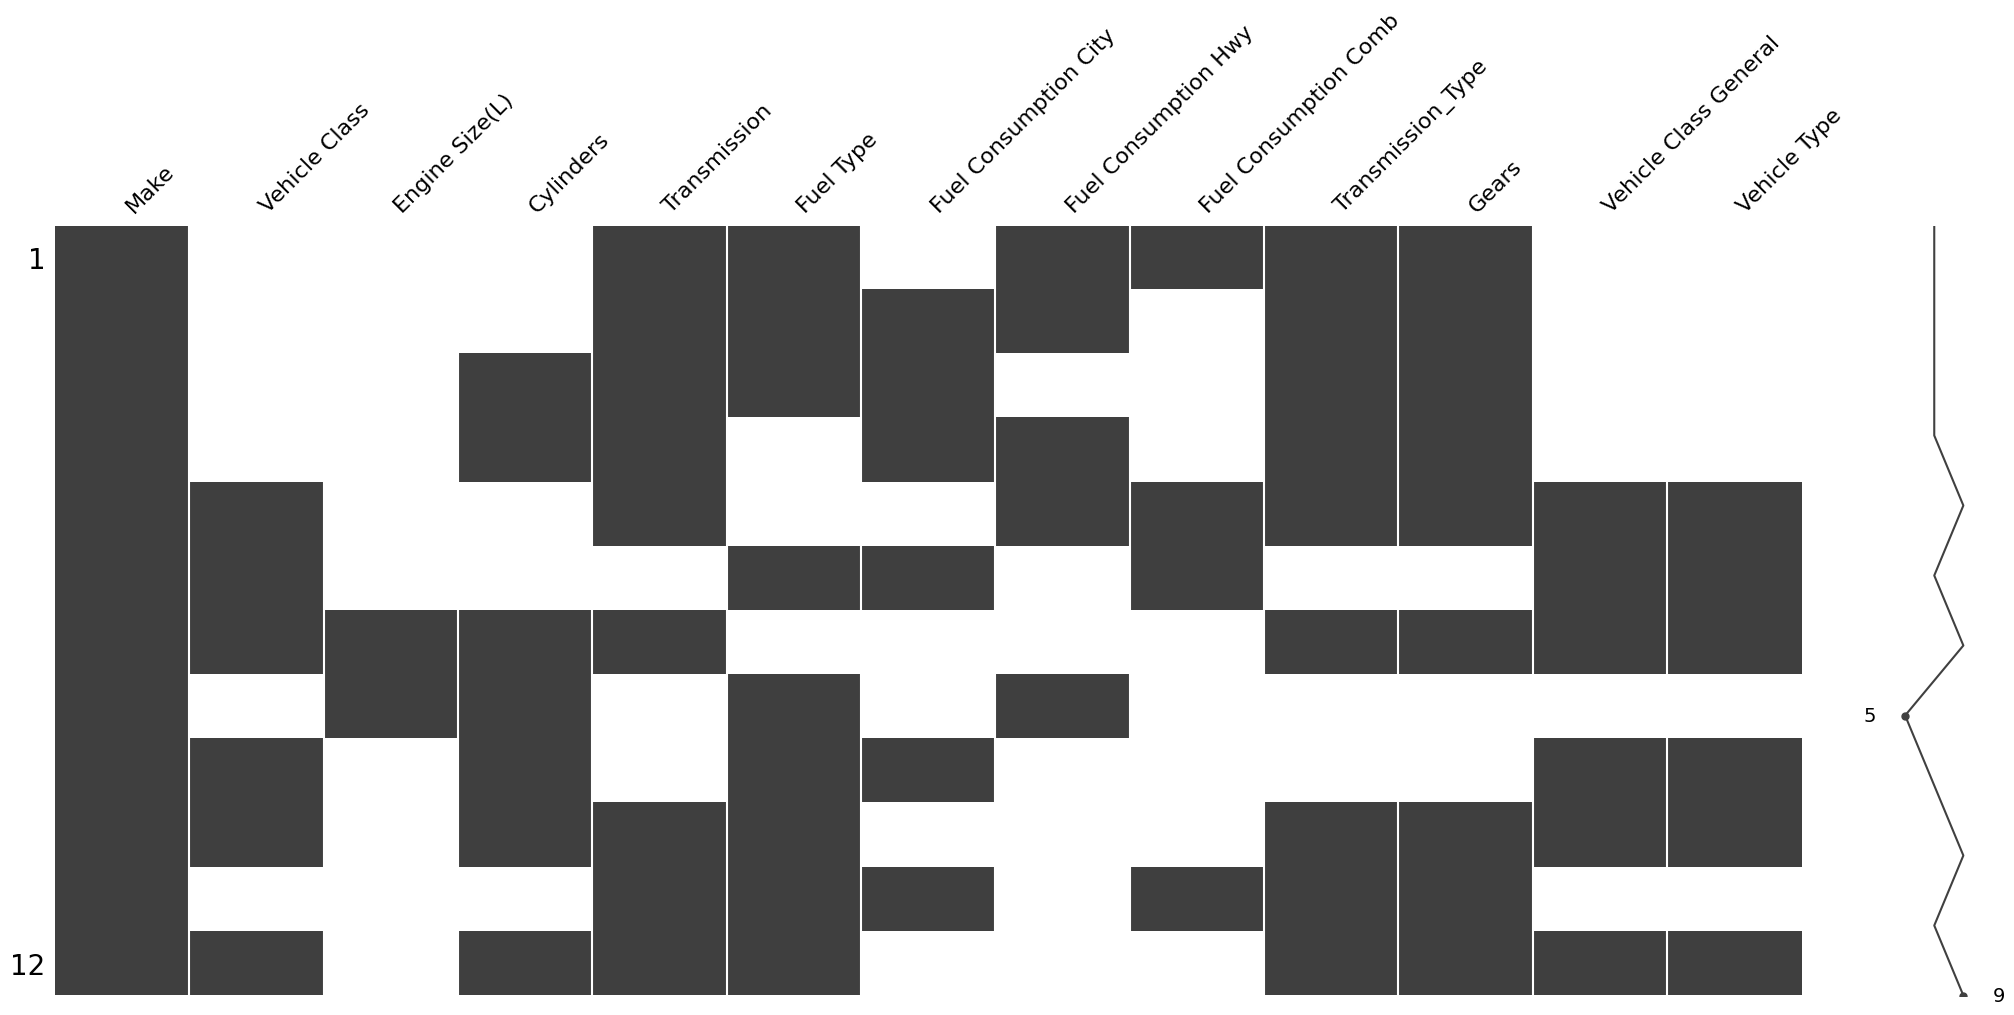

In [93]:
msno.matrix(multiple_missing_train)
msno.matrix(multiple_missing_test)

In [94]:
def calculate_iqr(df: pd.DataFrame, columns: list, multiplier: float):
    bounds = {}
    for column in columns:
        data = df[column].dropna()  # ignore NaN values
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        bounds[column] = (lower_bound, upper_bound)
    return bounds


def detect_outliers(df: pd.DataFrame, bounds: dict) -> pd.DataFrame:
    df["is_outlier"] = 0
    for column, (lower_bound, upper_bound) in bounds.items():
        df.loc[
            (df[column] < lower_bound) | (df[column] > upper_bound), "is_outlier"
        ] = 1
        print(
            f"Column: {column}, Number of Outliers: {sum((df[column] < lower_bound) | (df[column] > upper_bound))}"
        )
    return df

In [114]:

float_columns_df = df_train.select_dtypes(include=["float64"])
selected_columns = [
    # "Fuel Consumption City",
    # "Fuel Consumption Hwy",
    "Fuel Consumption Comb",
    "Engine Size(L)",
    "Cylinders"
]

In [117]:
bounds = calculate_iqr(df_train, float_columns_df, 1.5)
df_train = detect_outliers(df_train, bounds)
df_test = detect_outliers(df_test, bounds)

Column: Engine Size(L), Number of Outliers: 2005
Column: Cylinders, Number of Outliers: 540
Column: Fuel Consumption City, Number of Outliers: 479
Column: Fuel Consumption Hwy, Number of Outliers: 1578
Column: Fuel Consumption Comb, Number of Outliers: 570
Column: Gears, Number of Outliers: 0
Column: Engine Size(L), Number of Outliers: 887
Column: Cylinders, Number of Outliers: 219
Column: Fuel Consumption City, Number of Outliers: 195
Column: Fuel Consumption Hwy, Number of Outliers: 683
Column: Fuel Consumption Comb, Number of Outliers: 243
Column: Gears, Number of Outliers: 0


In [118]:
df_train['is_outlier'].value_counts()

is_outlier
0    51175
1     3762
Name: count, dtype: int64

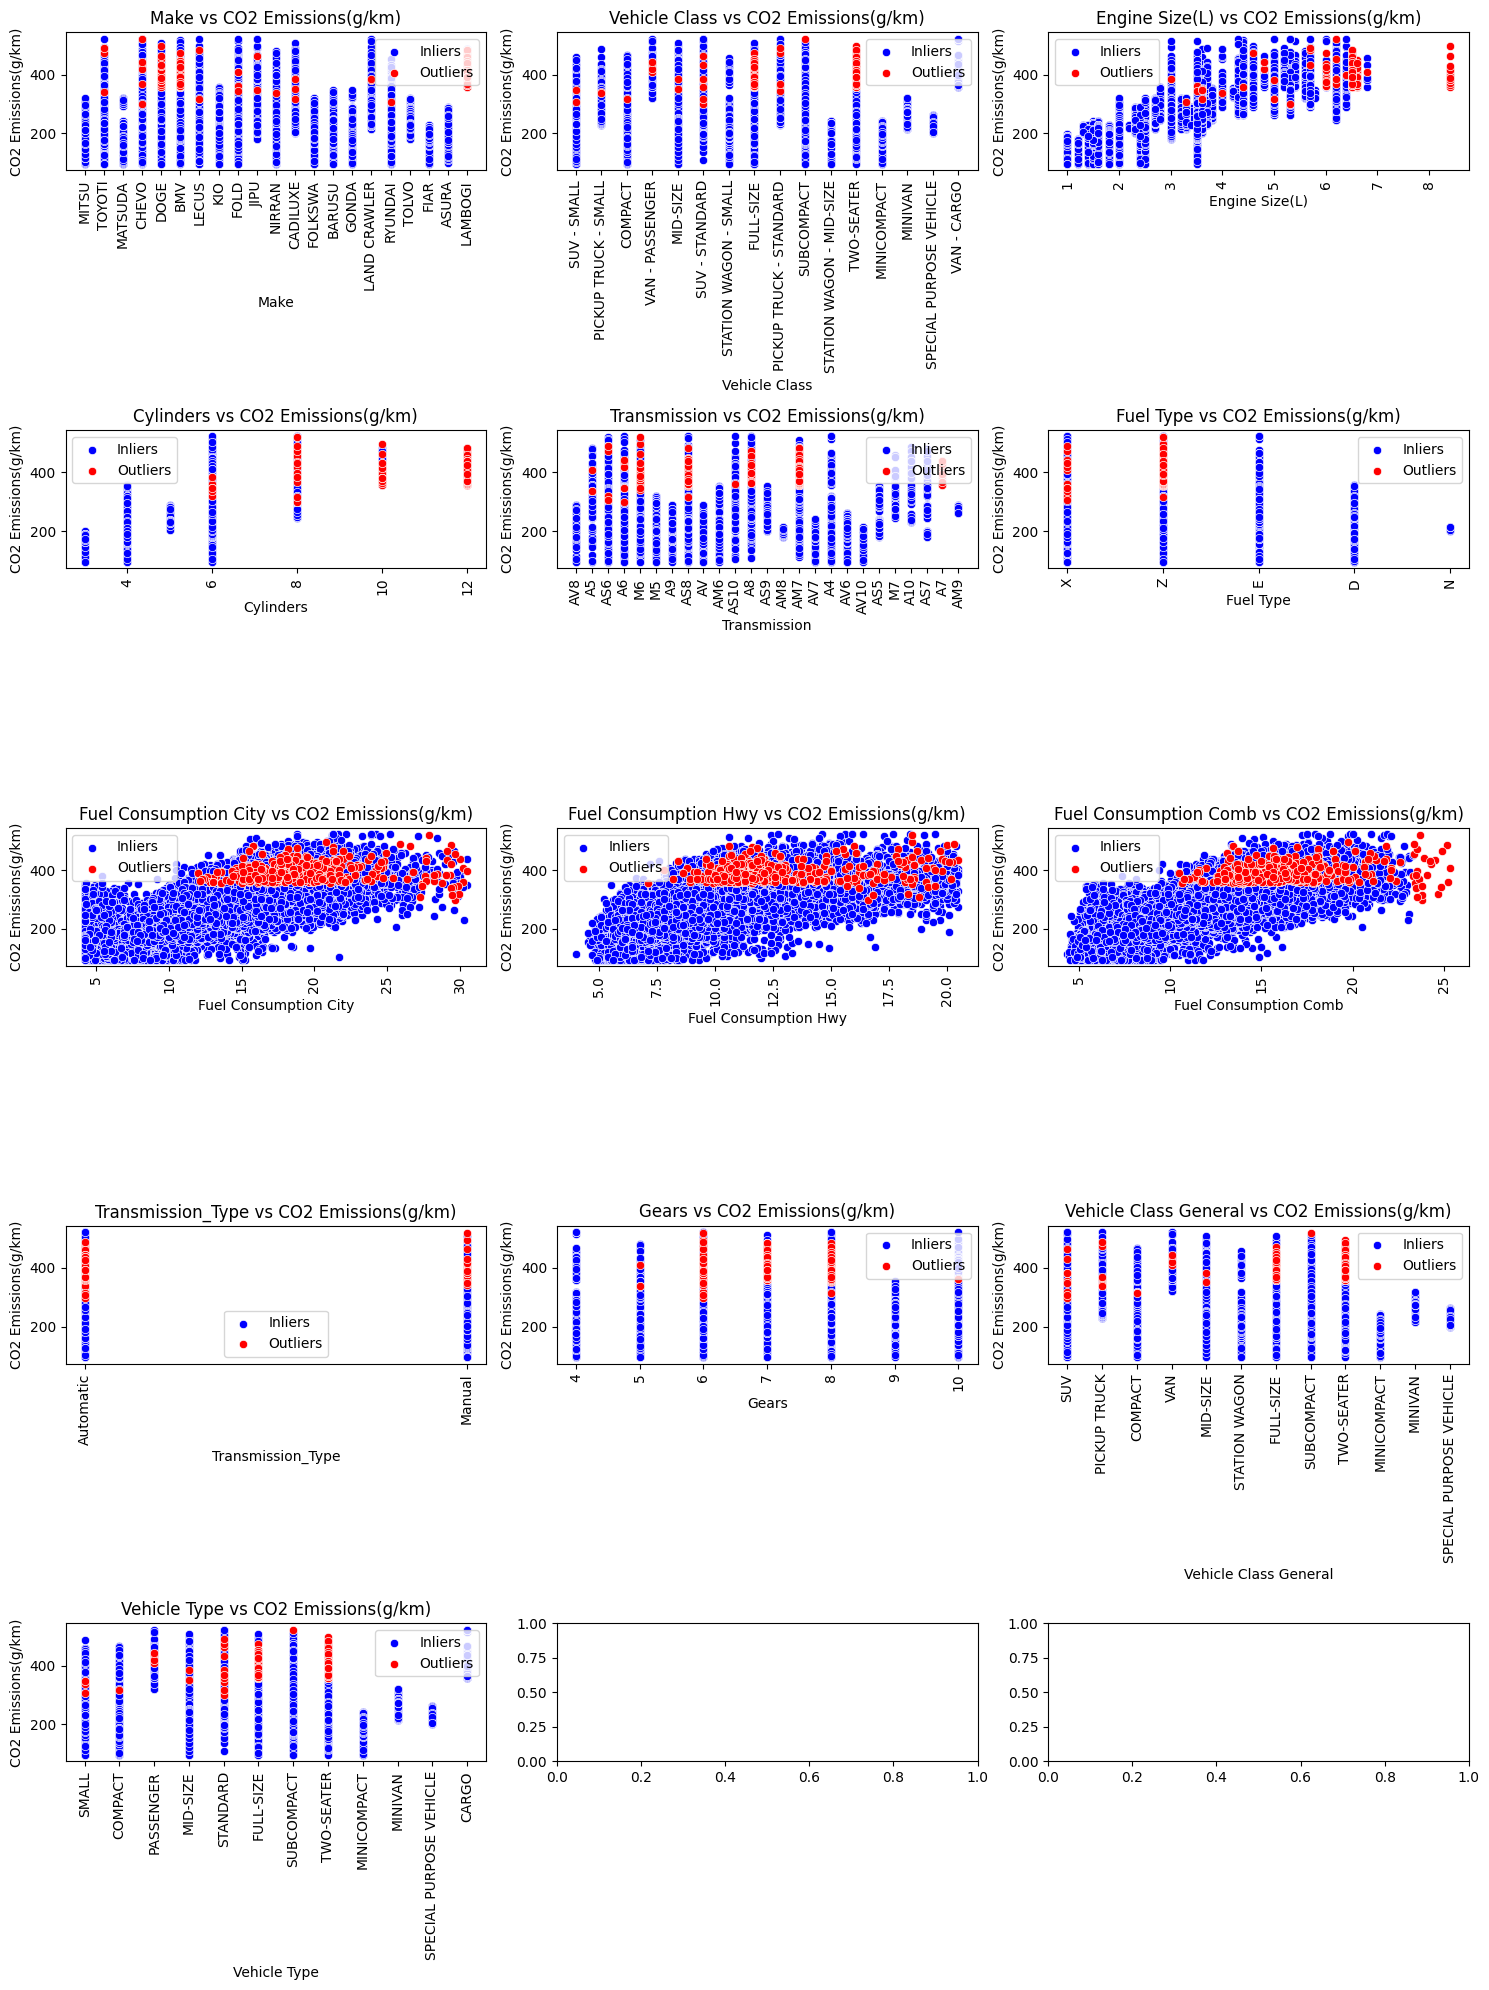

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

df_temp = pd.concat([df_train, df_train_target], axis=1)

# Assuming df is your DataFrame and "is_outlier" is the column where you marked outliers
outliers = df_temp[df_temp["is_outlier"] == 1]
inliers = df_temp[df_temp["is_outlier"] == 0]

# Get the list of features to plot
features = df_temp.columns.drop(["is_outlier", "CO2 Emissions(g/km)"])

fig, axes = plt.subplots(5, 3, figsize=(15, 20))


# Loop over the features and plot them against the CO2 emissions feature
for i, feature in enumerate(features):
    # Get the row and column index of the subplot
    row = i // 3
    col = i % 3

    # Scatter plot for inliers
    sns.scatterplot(
        x=inliers[feature],
        y=inliers["CO2 Emissions(g/km)"],
        color="b",
        label="Inliers",
        ax=axes[row, col],
    )

    # Scatter plot for outliers
    sns.scatterplot(
        x=outliers[feature],
        y=outliers["CO2 Emissions(g/km)"],
        color="r",
        label="Outliers",
        ax=axes[row, col],
    )

    # Set the title and labels of the subplot
    axes[row, col].set_title(f"{feature} vs CO2 Emissions(g/km)")
    axes[row, col].set_xlabel(feature)
    axes[row, col].tick_params(axis="x", rotation=90)
    axes[row, col].set_ylabel("CO2 Emissions(g/km)")
    axes[row, col].legend()

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plots
plt.show()

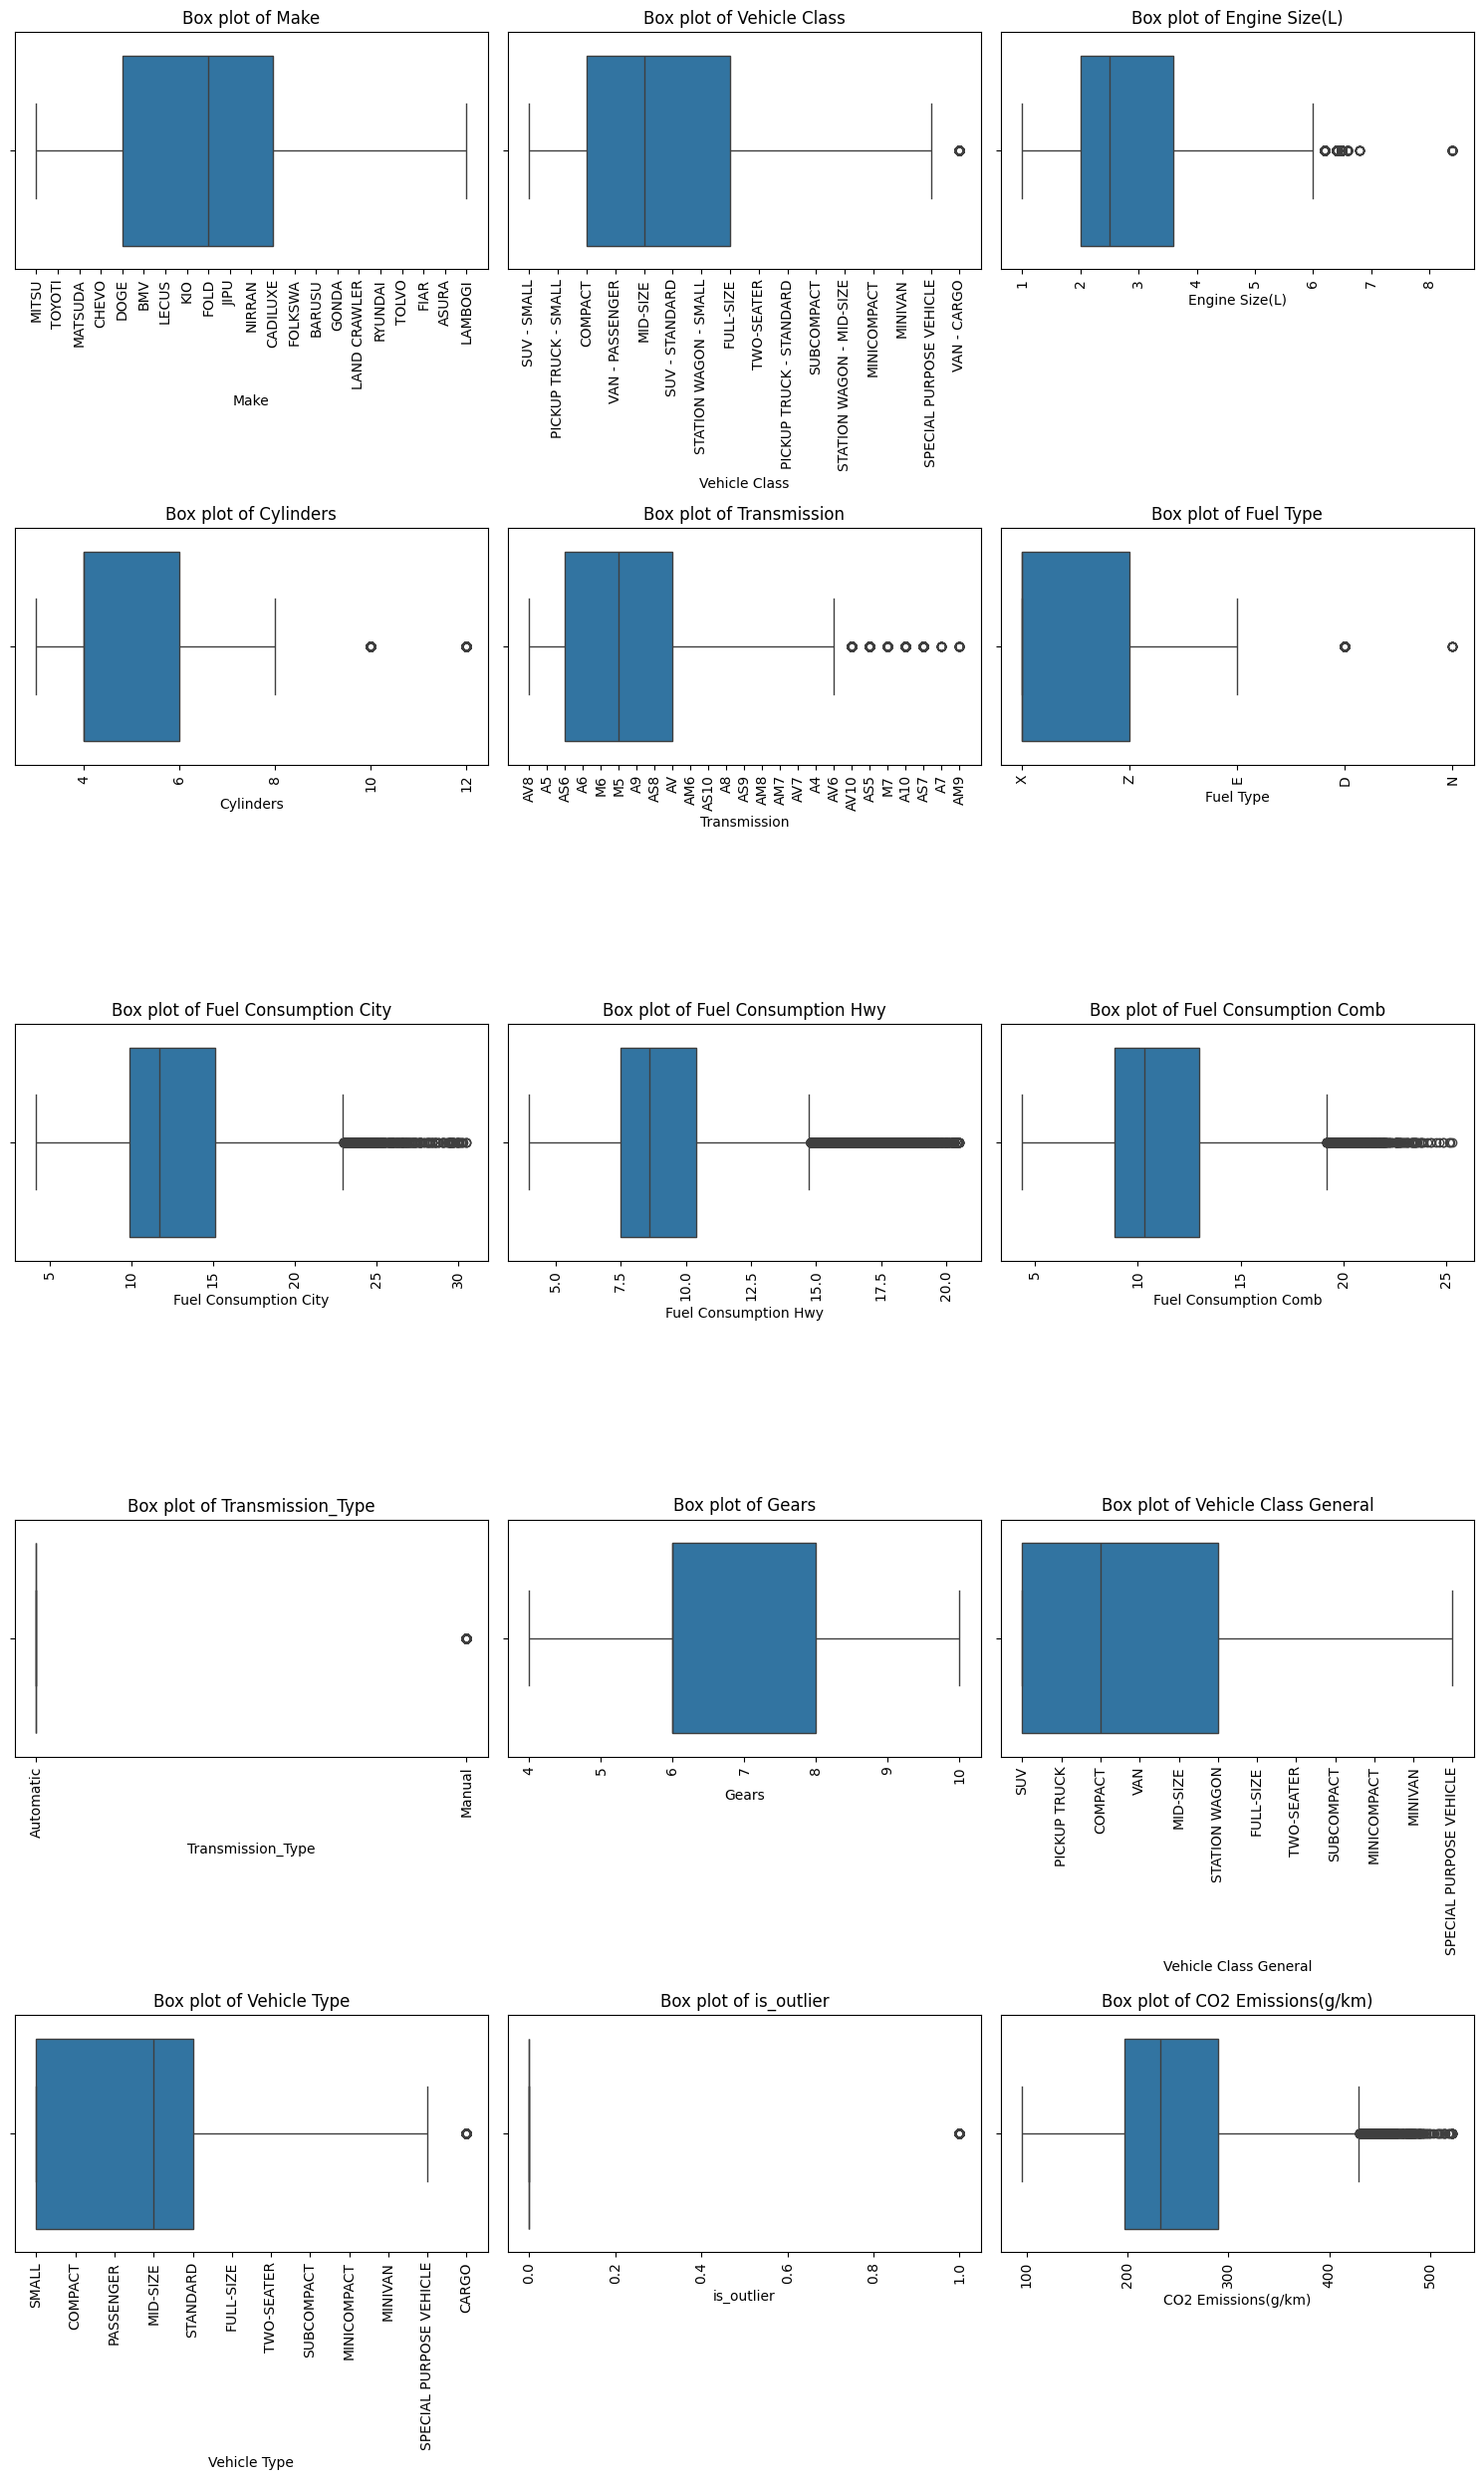

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_temp is your DataFrame
num_plots = len(df_temp.columns)
num_cols = 3
num_rows = (
    num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1
)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for i, column in enumerate(df_temp.columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=df_temp[column], ax=axs[row, col])
    axs[row, col].set_title(f"Box plot of {column}")
    axs[row, col].tick_params(axis="x", rotation=90)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

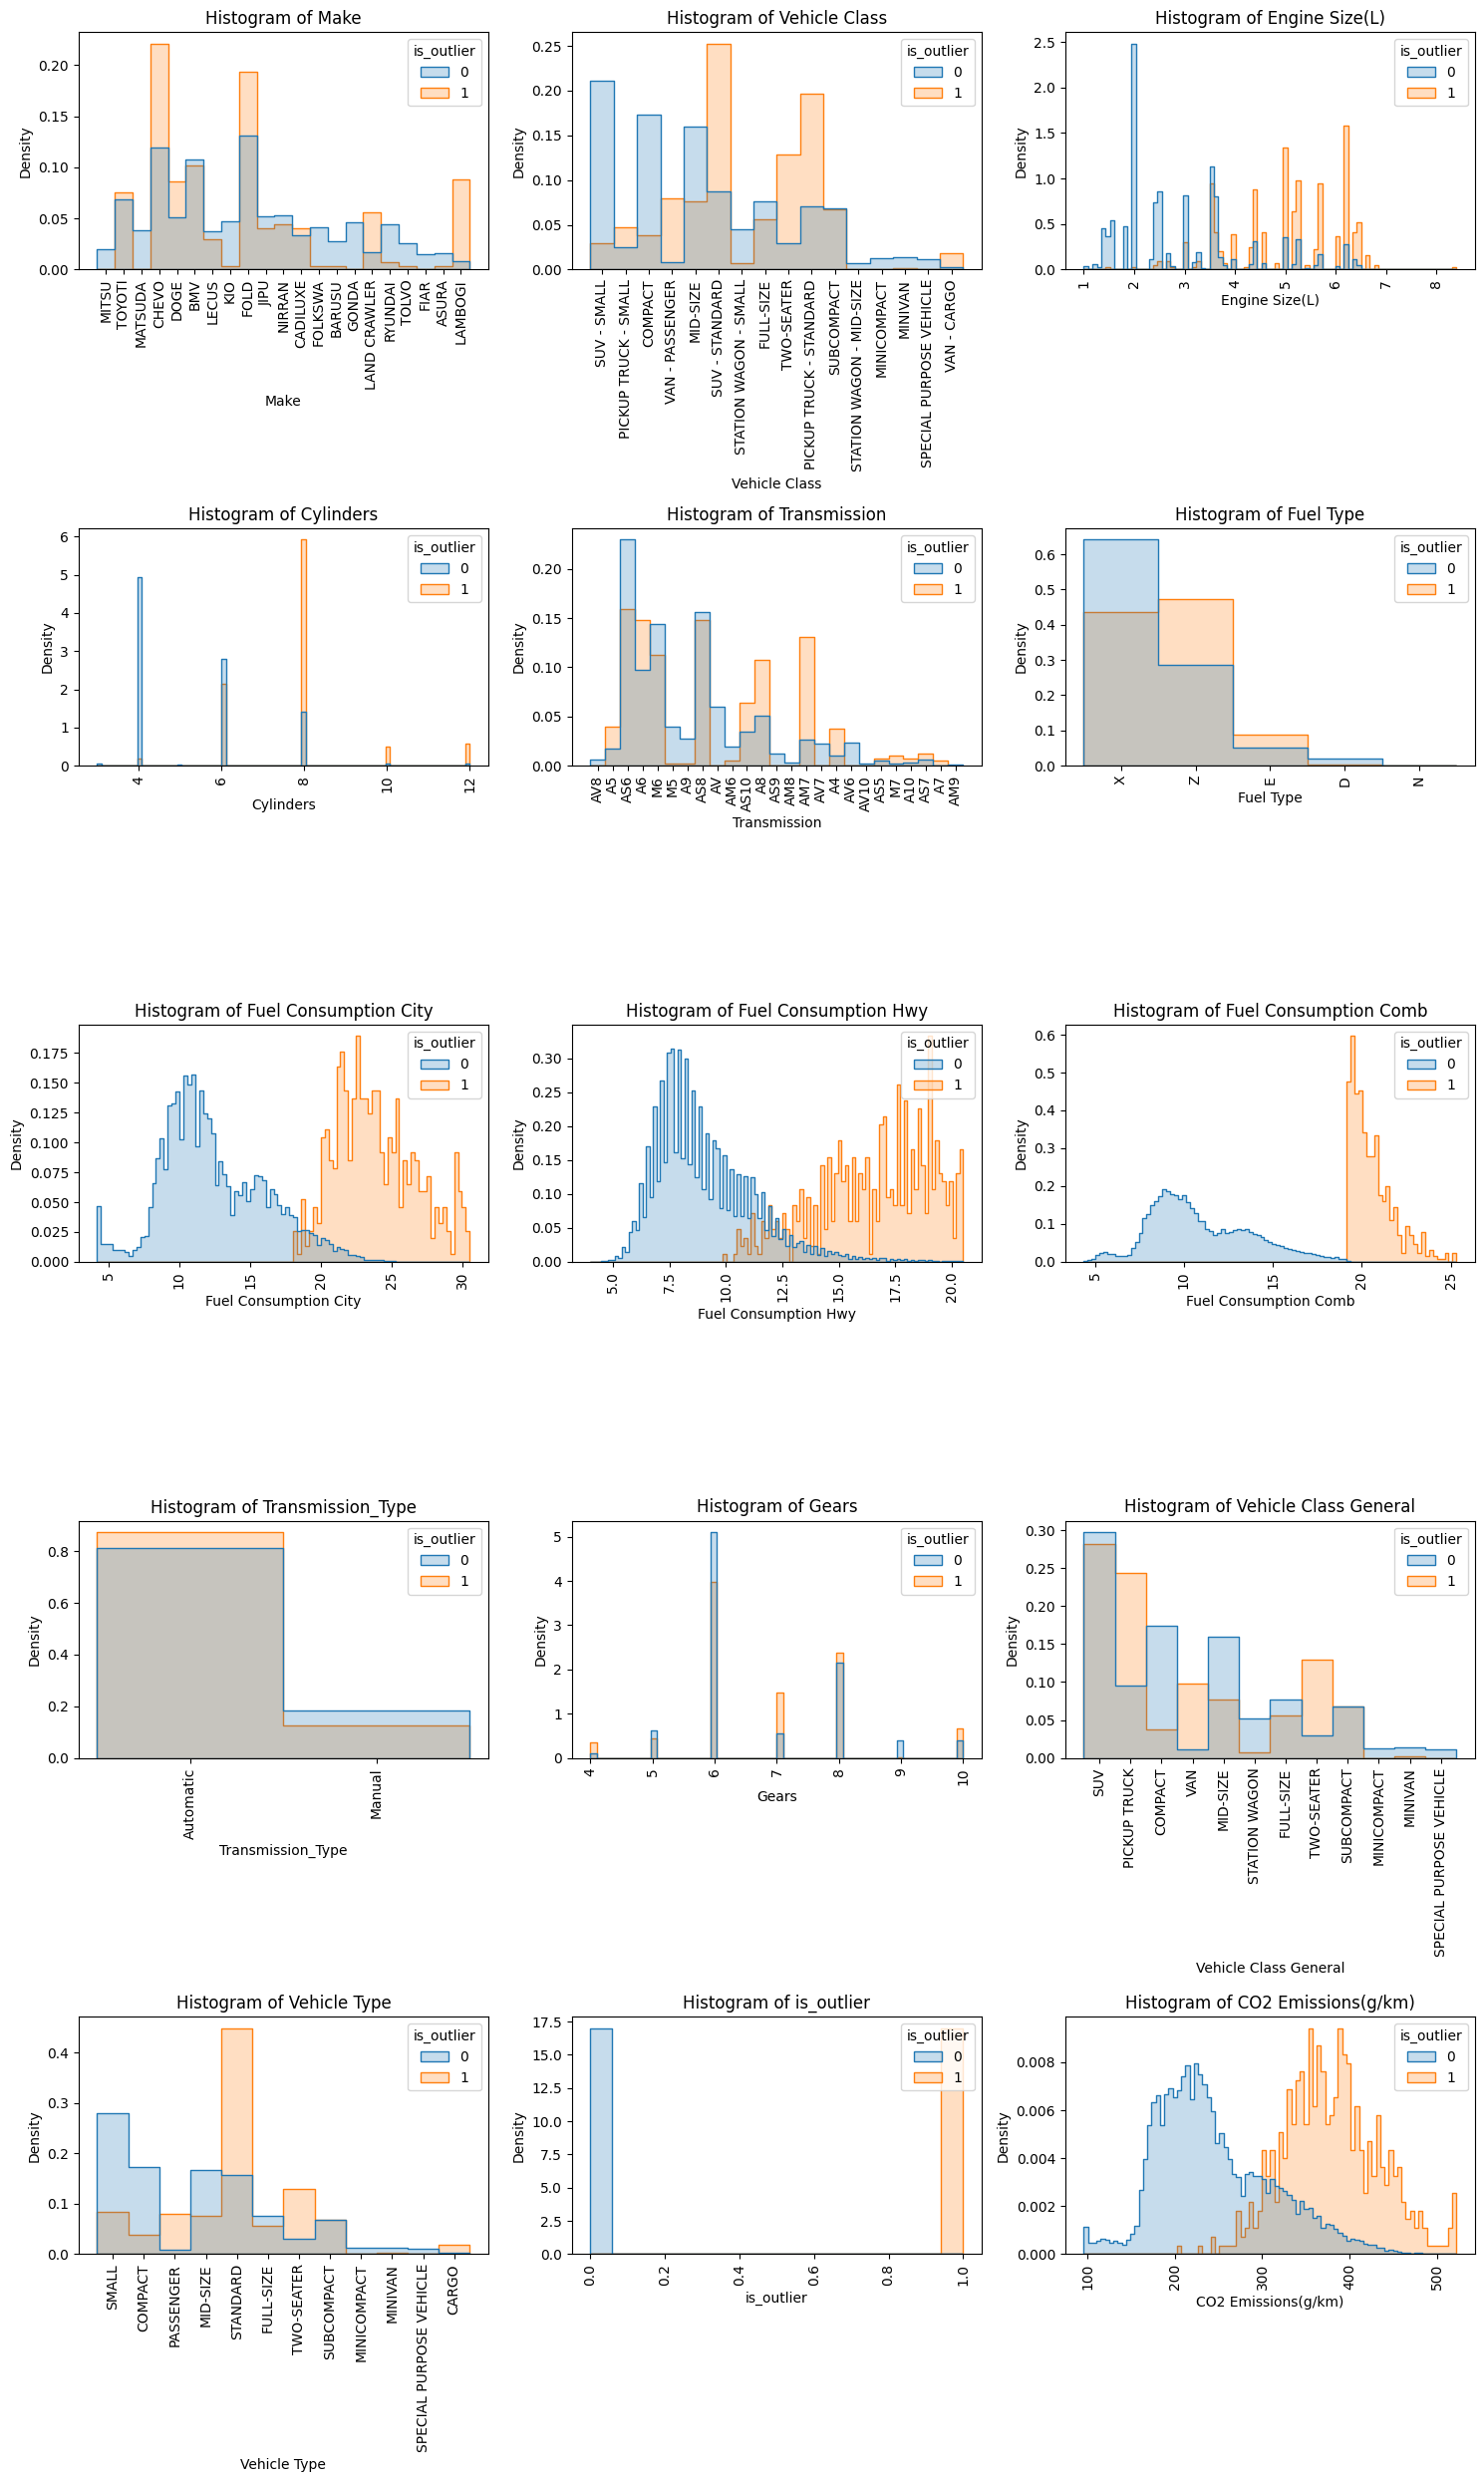

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_temp is your DataFrame
num_plots = len(df_temp.columns)
num_cols = 3
num_rows = (
    num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1
)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for i, column in enumerate(df_temp.columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(
        data=df_temp,
        x=column,
        hue="is_outlier",
        element="step",
        stat="density",
        common_norm=False,
        ax=axs[row, col],
    )
    axs[row, col].set_title(f"Histogram of {column}")
    axs[row, col].tick_params(axis="x", rotation=90)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

In [122]:
import pandas as pd
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest

import functions as func

df_temp = df_train.dropna()
numerical_columns = df_temp.select_dtypes(include=[np.number]).columns

df_test

# initialized a group of outlier detectors for acceleration
detector_list = [
    LOF(n_neighbors=15),
    LOF(n_neighbors=20),
    LOF(n_neighbors=25),
    LOF(n_neighbors=35),
    COPOD(),
    IForest(n_estimators=100),
    IForest(n_estimators=200),
]

# Initialize the model
clf = SUOD(
    base_estimators=detector_list, n_jobs=2, combination="average", verbose=False
)

# Fit the model
clf.fit(df_temp[numerical_columns])

# Predict the outliers
y_pred = clf.predict(df_temp[numerical_columns])

# Add the prediction to your dataframe
df_temp["is_outlier"] = y_pred

RandomForestRegressor()



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.1min finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   10.9s finished


In [125]:
df_temp["is_outlier"].value_counts()

is_outlier
0    30565
1     3200
Name: count, dtype: int64

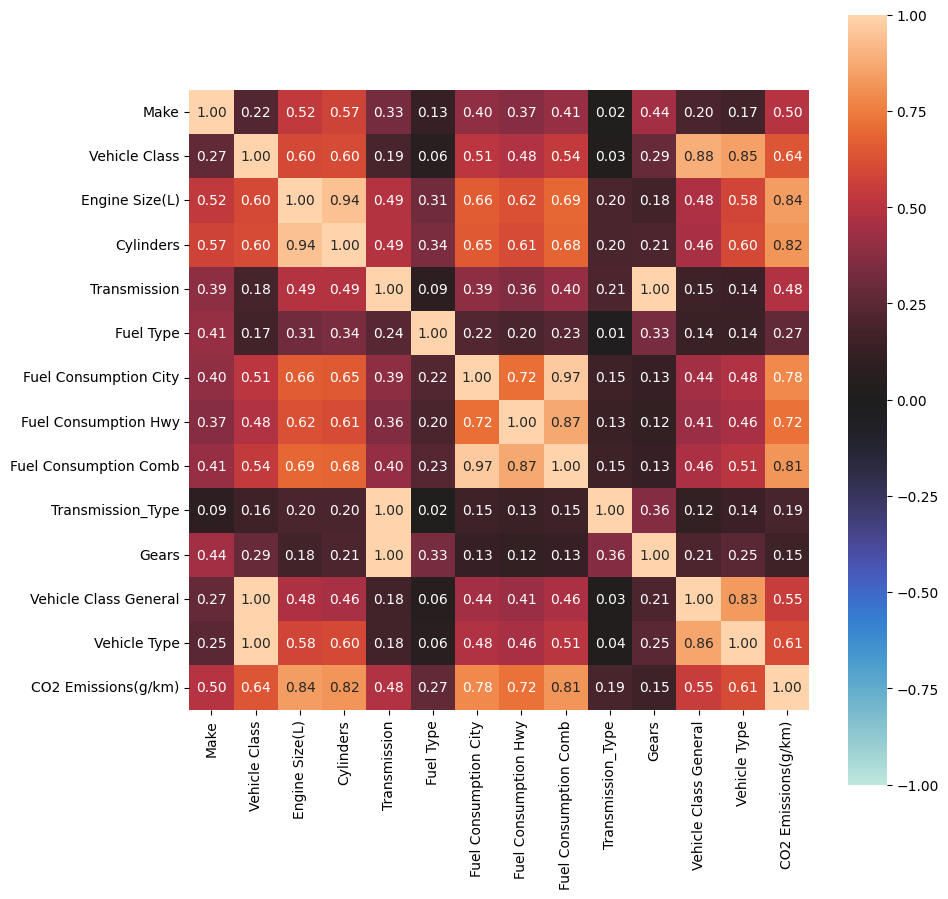

In [126]:
df_temp = pd.concat([df_train, df_train_target], axis=1)

from dython.nominal import associations

associations(
    df_temp,
    nom_nom_assoc="theil",
    plot=True,
    nan_strategy="drop_samples",
    # clustering=True,
    figsize=(10, 10),
)
print()

In [152]:
df_temp = df_train.join(df_train_target)
df_temp

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,Transmission_Type,Gears,Vehicle Class General,Vehicle Type,is_outlier,CO2 Emissions(g/km)
0,MITSU,SUV - SMALL,1.5,4.0,AV8,X,11.904762,7.200000,9.800000,Automatic,8.0,SUV,SMALL,0,208
1,TOYOTI,PICKUP TRUCK - SMALL,NaN,6.0,A5,X,13.793103,9.700000,11.960000,Automatic,5.0,PICKUP TRUCK,SMALL,0,325
2,MATSUDA,COMPACT,2.0,4.0,AS6,X,10.204082,7.299251,8.894238,Automatic,6.0,COMPACT,COMPACT,0,170
3,CHEVO,VAN - PASSENGER,NaN,8.0,A6,X,17.300000,11.700000,14.780000,Automatic,6.0,VAN,PASSENGER,0,362
4,TOYOTI,COMPACT,1.8,4.0,M6,X,8.100000,7.899357,8.010000,Manual,6.0,COMPACT,COMPACT,0,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54932,CHEVO,SUBCOMPACT,6.2,8.0,AS10,Z,11.900000,8.802817,10.505341,Automatic,10.0,SUBCOMPACT,SUBCOMPACT,1,318
54933,CHEVO,SUBCOMPACT,3.6,6.0,M6,X,21.000000,10.600000,16.323011,Manual,6.0,SUBCOMPACT,SUBCOMPACT,0,303
54934,FOLD,TWO-SEATER,3.5,6.0,AM7,Z,18.200000,12.500000,15.630000,Automatic,7.0,TWO-SEATER,TWO-SEATER,0,410
54935,CHEVO,PICKUP TRUCK - STANDARD,6.2,8.0,A8,Z,18.300000,9.900000,14.520000,Automatic,8.0,PICKUP TRUCK,STANDARD,1,466


c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\sesar\Documents\_PROJECTS\bebass\venv31011\lib\site-packages\dython\nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


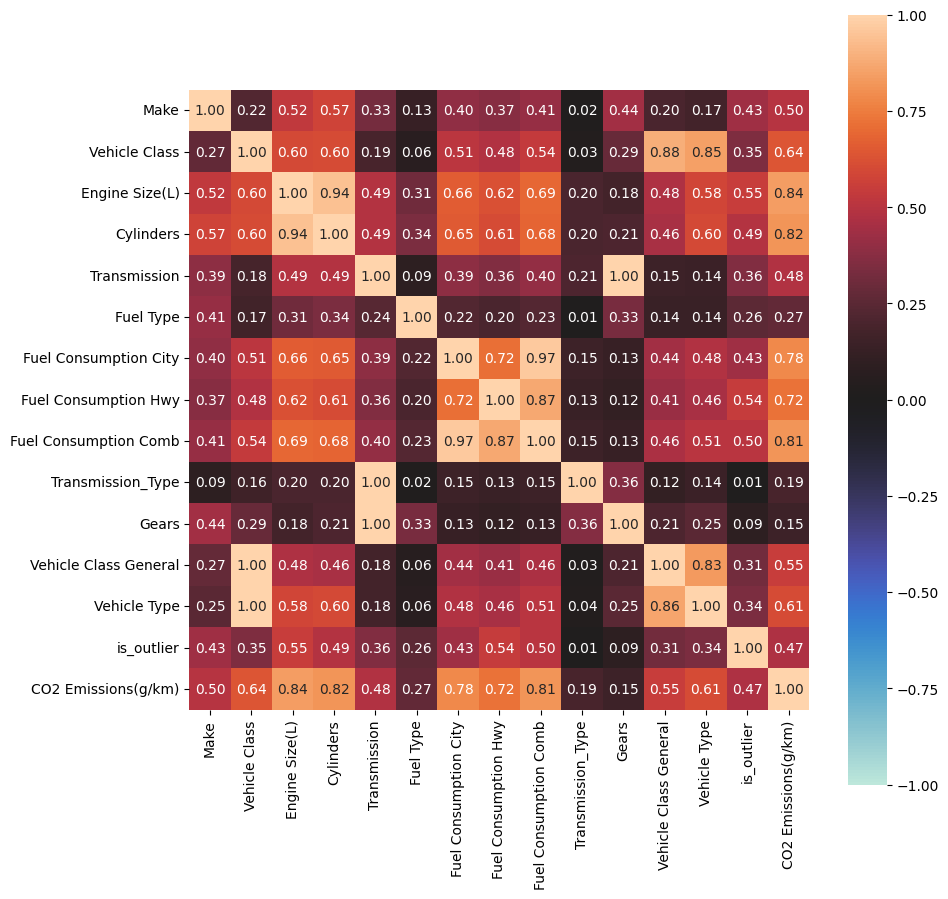

In [153]:
from dython.nominal import associations

associations(
    df_temp,
    nom_nom_assoc="theil",
    plot=True,
    nan_strategy="drop_samples",
    # clustering=True,
    figsize=(10, 10),
)
print()

In [154]:
df_train.insert(0, "Id", df_train_id)
df_train = pd.concat([df_train, df_train_target], axis=1)

df_test.insert(0, "Id", df_test_id)

df_train.to_csv("../dataset/train_cleaned_outliers_2.csv", index=False)
df_test.to_csv("../dataset/test_cleaned_outliers_2.csv", index=False)